## EXERCISE 1

| Nome | Cognome | Numero di matricola |
|------|---------|---------------------|
| Lucrezia | Rossi | 2122164 |
| Lorenzo | Calandra Buonaura | |
| Andrea | Turci | |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D

1. The lesson discussed two CNN versions: one ending with a global max pooling layer (G), and one
ending with a dense layer (D).
Choose one of the two G and D versions for the remaining exercise, motivating your choice.

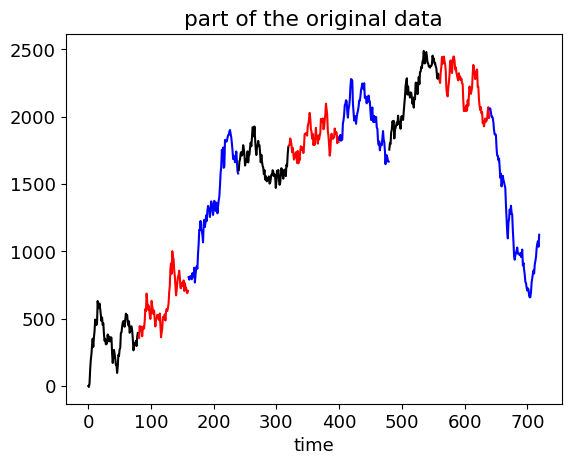

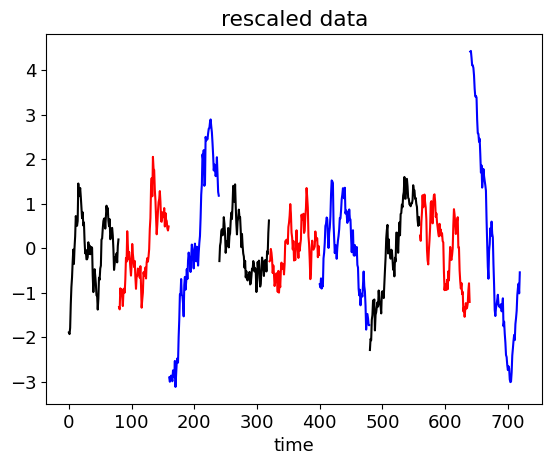

N_train= 3200   N_val= 800   L= 80   n_class= 3

----- Model 2 -----
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 70, 5)             60        
                                                                 
 conv1d_1 (Conv1D)           (None, 67, 5)             105       
                                                                 
 conv1d_2 (Conv1D)           (None, 64, 5)             105       
                                                                 
 global_max_pooling1d (Glob  (None, 5)                 0         
 alMaxPooling1D)                                                 
                                                                 
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 3)               

In [2]:
def Show_data(x,L,s="data",T=3):
    c=("k","r","b")
    for i in range(T):
        j=i*3*L
        plt.plot(np.arange(j,j+L),x[i*3],c=c[0])
        plt.plot(np.arange(j+L,j+2*L),x[i*3+1],c=c[1])
        plt.plot(np.arange(j+2*L,j+3*L),x[i*3+2],c=c[2])
    plt.title(s)
    plt.xlabel("time")
    plt.show()
    
str0="ts_L80_N4000.dat"
fnamex='x_'+str0
fnamey='y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"part of the original data")

categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
#print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.
# bring each sample to zero average
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

#rescale (crude version, variance should be used)
x = x / x.std()
    
Show_data(x,L,"rescaled data")

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

# reproducibility
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)
NCONV=2 #change this for see the result of the different model

def build_model(NCONV=1, NF=5,KS=6, NF2=5,KS2=4, lamb=0):
    """
    filter = kernel
    NCONV=index of the CNN architecture
    NF=nr of filters in the 1st layer
    KS=kernel size in the 1st layer
    NF2=nr of filters in the 2nd layer
    KS2=kernel size in the 2nd layer
    lamb=not the animal, but lambda, the regularization parameter
    """
    # regularizers, l2=Ridge, l1=LASSO
    reg = keras.regularizers.l2(lamb)
    model = Sequential()

    # Version with last layer Dense
    if NCONV==1:
        model.add(Conv1D(filters=5, 
                         kernel_size=KS,
                         kernel_regularizer=reg,
                         activation='relu', 
                         input_shape=input_shape))
        model.add(MaxPooling1D(3))
        #model.add(AveragePooling1D(3))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
        model.add(Flatten())
        model.add(Dense(12, activation='relu'))
        model.add(Dropout(0.2))

    # Version with last layer GlobalMaxPooling, one more intermediate conv1D, and no intermediate pooling
    if NCONV==2:
        model.add(Conv1D(filters=NF, 
                         kernel_size=KS,
                         kernel_regularizer=reg,
                         activation='relu', 
                         input_shape=input_shape))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
        model.add(tf.keras.layers.GlobalMaxPooling1D())
        model.add(Flatten())
        
    # Last layer, with n_class units  
    model.add(Dense(n_class, activation='softmax')) # softmax !
    
    # optimizers
    # .SGD(lr=0.01, momentum=0.9, nesterov=True) # decay=1e-6,
    # .RMSprop()
    # .Nadam()
    # Define the optimizer learning rate as a hyperparameter.
    opt = keras.optimizers.Adam()
    
    # compile the model
    # categorical_crossentropy, 3 output nodes
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])
    return model

model=build_model(NCONV=NCONV,KS=11)


print('----- Model',NCONV,'-----')
print(model.summary())

# optimizers
# .SGD(lr=0.01, momentum=0.9, nesterov=True) # decay=1e-6,
# .RMSprop()
# .Nadam()
opt = tf.keras.optimizers.Adam()

# compile the model
# categorical_crossentropy, 3 output nodes
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,metrics=['accuracy'])

print(model.layers)

#### Answer:
La risposta è G perchè ci sono meno parametri e quindi diminuiscono i costi computazionali (da scrivere meglio)

2. Try different optimizers, including at least Adam, RMSprop, and Nesterov. Each one should be
tested for at least five values of the learning rate η (for example, including 10 $^{-5}$, 10 $^{-4}$, 10 $^{-3}$). The
range could be different for different algorithms. Moreover, at least five fits per model should be collected to obtain statistics with an average and standard deviation of the model’s validation accuracy. Plot all results in a single panel of a figure as a function of η.

In [18]:
# Definisci la griglia degli iperparametri
optimizers = [keras.optimizers.Adam, keras.optimizers.RMSprop, keras.optimizers.SGD]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
BATCH_SIZE = 200
EPOCHS = 300
results = []

for optimizer in optimizers:
    optimizer_name = optimizer.__name__
    mean_val_accuracies_optimizer = []
    std_val_accuracies_optimizer = []

    for learning_rate in learning_rates:
        # Costruisci e compila il modello con l'ottimizzatore e il tasso di apprendimento corrente
        opt = optimizer(learning_rate=learning_rate)
        model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

        # Addestra il modello
        fit = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val, y_val), verbose=0, shuffle=True)
        val_accuracies = fit.history['val_accuracy']

        # Calcola la media e la deviazione standard dei valori di accuratezza della validazione per l'ottimizzatore corrente e il learning rate corrente
        mean_val_accuracy_lr = np.mean(val_accuracies)
        std_val_accuracy_lr = np.std(val_accuracies)

        mean_val_accuracies_optimizer.append(mean_val_accuracy_lr)
        std_val_accuracies_optimizer.append(std_val_accuracy_lr)

    results.append({
        'optimizer': optimizer_name,
        'learning_rates': learning_rates,
        'mean_val_accuracy': mean_val_accuracies_optimizer,
        'std_val_accuracy': std_val_accuracies_optimizer
    })
print(results)

[{'optimizer': 'Adam', 'learning_rates': [1e-05, 0.0001, 0.001, 0.01, 0.1], 'mean_val_accuracy': [0.7825500130653381, 0.7785624818007151, 0.7798999897638956, 0.7774083266655604, 0.7685374965270361], 'std_val_accuracy': [0.0010789716882641108, 0.0014934854139522207, 0.0013386933788407224, 0.00412840412984687, 0.016580347457632514]}, {'optimizer': 'RMSprop', 'learning_rates': [1e-05, 0.0001, 0.001, 0.01, 0.1], 'mean_val_accuracy': [0.7780916591485342, 0.7748708228270212, 0.7783833209673564, 0.7778583319981893, 0.7131125007073085], 'std_val_accuracy': [0.003472206245998441, 0.001590651259688652, 0.0015515226238709164, 0.006701737336204747, 0.045864210794045714]}, {'optimizer': 'SGD', 'learning_rates': [1e-05, 0.0001, 0.001, 0.01, 0.1], 'mean_val_accuracy': [0.730825004975001, 0.7537249980370203, 0.7653583308060964, 0.7713291595379511, 0.7695499972502391], 'std_val_accuracy': [0.006735057900822007, 0.006285688056194987, 0.00296976234428118, 0.0017407426827873475, 0.00334564102549185]}]


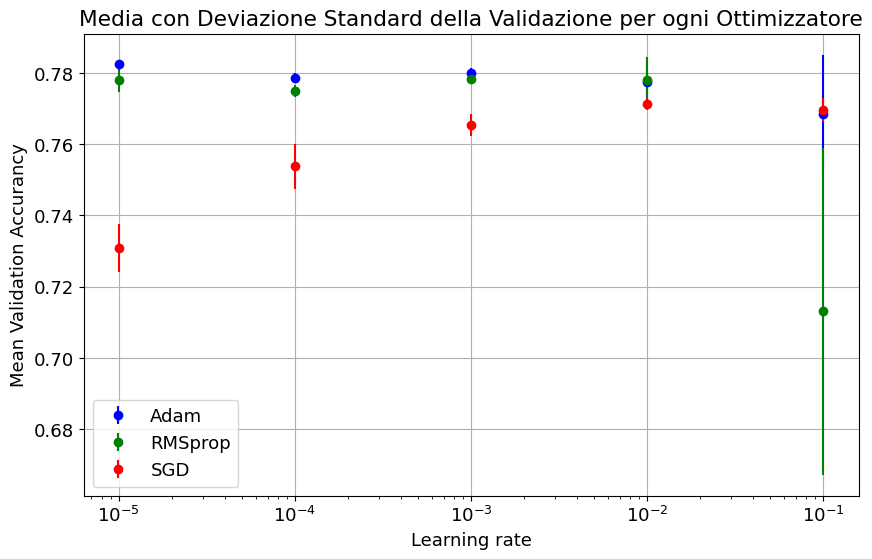

In [23]:
# Definisci i colori per ogni ottimizzatore
colors = ['blue', 'green', 'red']

# Crea il plot
plt.figure(figsize=(10, 6))

for i, result in enumerate(results):
    optimizer_name = result['optimizer']
    learning_rates = result['learning_rates']
    mean_val_accuracy = result['mean_val_accuracy']
    std_val_accuracy = result['std_val_accuracy']
    color = colors[i]
    
    # Plot della media con la deviazione standard
    plt.errorbar(learning_rates, mean_val_accuracy, yerr=std_val_accuracy, fmt='o', label=optimizer_name, color=color)

# Impostazioni del plot
plt.title('Media con Deviazione Standard della Validazione per ogni Ottimizzatore')
plt.xlabel('Learning rate')
plt.ylabel('Mean Validation Accurancy')
plt.xscale('log')
plt.legend()
plt.grid(True)

# Mostra il plot
plt.show()

3. Choose one among the best CNNs in step 2 (there could be equivalent ones within error bars).
Using that CNN, try to understand the hidden patterns. Introduce regularization and study the
kernels of the first layer, also by varying their length and their number (respectively, KS and NF in
the notebook). Report your findings, including eventually improved validation accuracy, thanks to
the regularization. However, note that this point’s scope differs from optimizing the validation
accuracy: it focuses on interpreting the kernel shapes.